In [1]:
# Importing Packages

import numpy as np
import matplotlib.pyplot as plt
import time

from typing import Optional, Union

import jax
import jax.numpy as jnp
from jax.scipy.special import erf
from jax import jit, vmap, block_until_ready, config

from algos.ppo import PPO_make_train

In [2]:
# Seeding everything

seed = 30

rng = jax.random.PRNGKey(seed)
rng, _rng = jax.random.split(rng)

In [60]:
# Defining all constants

KAPPA = 20.0
CHI = 0.65 * 2 * jnp.pi
N_MAX = 233
N_DEFAULT = 43 # assume all measurement are till steady-state, ie around 10/kappa = 400ns
mu_default = jnp.sqrt(N_MAX / N_DEFAULT)
amp_default = 1/mu_default
GAMMA_PHOTON = 1/1500
GAMMA_MEAS = 1/140
INIT_FID = 1 - 1e-4
SNR_SCALE = 1.9
STATE_STD = 1/jnp.sqrt(2)

In [61]:
def SS_meas_pF(
    amp, 
    ts
):
    '''
    Where amp is defined to take values between 0 and 1 like with IBMQ convention
    and ts is a sufficiently large linspace
    returns pF_res with shape (AMPS, TS)
    '''
    amp = amp.reshape(-1, 1)
    ts = ts.reshape(1, -1)
    amp_max = 0.5 * jnp.sqrt(N_MAX * (KAPPA ** 2 + CHI ** 2))
    photon = N_MAX * amp**2
    amp *= amp_max
    separation = (4 * amp * SNR_SCALE / (KAPPA ** 2 + CHI ** 2) 
                  * (CHI * (1. - jnp.exp(-0.5 * KAPPA * ts)) - 0.5 * KAPPA * CHI * ts * jnp.exp(-0.5 * KAPPA * ts)))
    separation_fid = 0.5 * (1. + erf(separation / (2 * jnp.sqrt(2) * STATE_STD)))
    decay_fid = INIT_FID * jnp.exp(-( 
        (GAMMA_PHOTON * photon + GAMMA_MEAS) * ts 
        - 4 * GAMMA_PHOTON * photon / KAPPA * (1. - jnp.exp(-0.5 * KAPPA * ts)) 
        + GAMMA_PHOTON * photon / KAPPA * (1. - jnp.exp(-KAPPA * ts)) 
        )
    )
    pF_res = -jnp.log10(1. - separation_fid * decay_fid)
    max_fidelity = jnp.max(pF_res, axis=-1)
    ts = ts.reshape(-1)
    time_of_max = ts[jnp.argmax(pF_res, axis=-1)]
    return pF_res, max_fidelity, time_of_max

In [62]:
ts = jnp.linspace(0., 0.4, 401)
amp_linspace = jnp.linspace(0.1, 1.0, 46)

batched_pF_res, batched_max_fidelity, batched_times = SS_meas_pF(amp_linspace, ts)

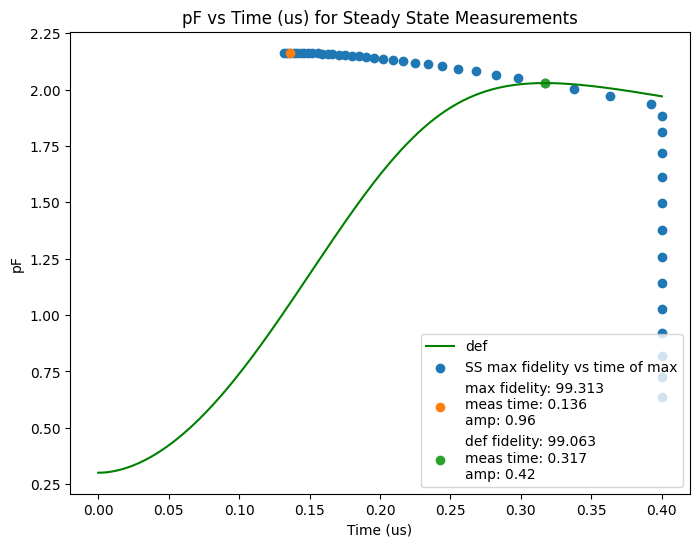

In [63]:
plt.figure(figsize=(8., 6.))
default_amp_ind = jnp.argmin(jnp.abs(amp_linspace - amp_default))
ss_fidelites = 1. - 10**(-batched_max_fidelity)

plt.plot(ts, batched_pF_res[default_amp_ind], label='def', color='green')
plt.scatter(batched_times, batched_max_fidelity, label='SS max fidelity vs time of max')
plt.scatter(
    batched_times[jnp.argmax(batched_max_fidelity)], 
    jnp.max(batched_max_fidelity), 
    label=f'max fidelity: {int(1e5*jnp.max(ss_fidelites)) / 1e3}\nmeas time: {int(1e3*batched_times[jnp.argmax(batched_max_fidelity)]) / 1e3}\namp: {int(1e3*amp_linspace[jnp.argmax(batched_max_fidelity)])/1e3}')
plt.scatter(
    batched_times[default_amp_ind], 
    batched_max_fidelity[default_amp_ind], 
    label=f'def fidelity: {int(1e5*jnp.max(ss_fidelites[default_amp_ind])) / 1e3}\nmeas time: {int(1e3*batched_times[default_amp_ind]) / 1e3}\namp: {int(1e3*amp_linspace[default_amp_ind])/1e3}')
plt.xlabel('Time (us)')
plt.ylabel('pF')
plt.title('pF vs Time (us) for Steady State Measurements')
plt.legend()
plt.show()

In [64]:
# Defining Cairo Params and RL Params

tau_0 = 0.398
kappa = 20.0
chi = 0.65 * 2. * jnp.pi
kerr = 0.002
gamma = 1/140
time_coeff = 10.0
snr_coeff = 10.0
smoothness_coeff = 10.0
n0 = 43
res_amp_scaling = 1/0.43
actual_max_photons = n0 * (1 - jnp.exp(-0.5 * kappa * tau_0))**2
print(f"Rough Max Photons: {n0}")
print(f"Actual Max Photons: {actual_max_photons}")
nR = 0.1
snr_scale_factor = 1.9
gamma_I = 1/140
num_t1 = 6.0
photon_gamma = 1/1500
init_fid = 1 - 1e-4
photon_weight = 4.0

batchsize = 64
num_envs = 8
num_updates = 1000
config = {
    "LR": 3e-3,
    "NUM_ENVS": num_envs,
    "NUM_STEPS": batchsize,
    "NUM_UPDATES": num_updates,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": int(batchsize * num_envs / 64),
    "CLIP_EPS": 0.2,
    "VALUE_CLIP_EPS": 0.2,
    "ENT_COEF": 0.0,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "relu6",
    "LAYER_SIZE": 256,
    "ENV_NAME": "photon_langevin_readout_env",
    "ANNEAL_LR": False,
    "DEBUG": True,
    "DEBUG_ACTION": False,
    "PRINT_RATE": 100,
    "ACTION_PRINT_RATE": 100,
}

Rough Max Photons: 43
Actual Max Photons: 41.40804860100575


In [65]:
single_train = jit(PPO_make_train(config), static_argnums=(-2, -1))

print(f"Starting a Run of {num_updates} Updates")
start = time.time()
single_result = single_train(
    _rng, 
    kappa,
    chi,
    kerr,
    time_coeff,
    snr_coeff,
    smoothness_coeff,
    n0,
    tau_0,
    res_amp_scaling,
    nR,
    snr_scale_factor,
    gamma_I,
    photon_gamma,
    num_t1,
    init_fid,
    photon_weight,
    batchsize, 
    num_envs)
print(f"time taken: {time.time() - start}")

Starting a Run of 1000 Updates
global update: 100
mean batch reward: [22.70897867 22.82291624 22.76744486 22.99074378 22.80267106 23.10073574
 23.00098984 23.00336349]
mean batch pF: [2.56604002 2.56574383 2.56592359 2.56478728 2.56597092 2.56576892
 2.56595382 2.56628843]
mean batch photon: [37.67258835 37.37789154 37.694561   36.99908447 37.88845062 36.84951019
 37.34954834 37.55870056]
mean batch photon time: [0.25806787 0.25451164 0.25352746 0.25096981 0.25153166 0.25050072
 0.25080904 0.25041936]
mean batch smoothness: [0.00178337 0.00151549 0.0019411  0.0011178  0.0028815  0.00206418
 0.00231478 0.00154251]
max reward obtained: [23.34631576 23.37839816 23.35726932 23.40021534 23.34913976 23.3834528
 23.38409052 23.34174446]
pF at max: [2.56083598 2.56675494 2.56875885 2.5659141  2.5670721  2.56723402
 2.56511445 2.56779616]
photon at max: [33.93094635 38.17683411 37.89461136 39.97779465 35.48586273 37.21030807
 39.12233734 37.1334877 ]
photon time of max: [0.24940658 0.25833333 0

In [66]:
# Extracting Results

metrics = single_result["metrics"]

max_actions = metrics["action of max"]
max_rewards = metrics["max reward obtained"]
max_photons = metrics["photon at max"]
max_pFs = metrics["pF at max"]
max_times = metrics["photon time of max"]
max_smoothness = metrics["smoothness at max"]
mean_rewards = metrics["mean batch reward"]
mean_pFs = metrics["mean batch pF"]
mean_photons = metrics["mean batch photon"]
mean_photon_times = metrics["mean batch photon time"]
mean_smoothness = metrics["mean batch smoothness"]
std_reward = metrics["std batch reward"]

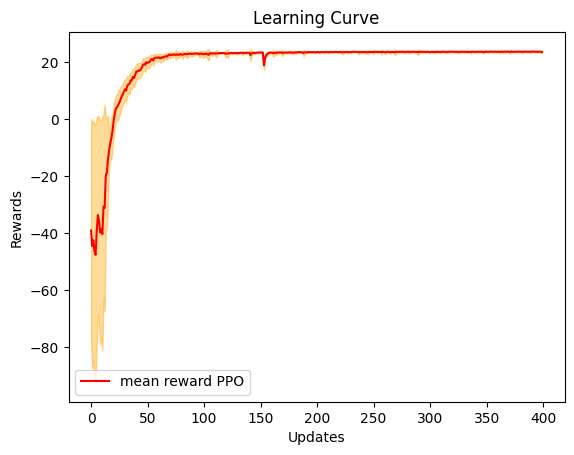

In [67]:
env_ind = 0
update_plot = 400

x = np.arange(update_plot)
m_plot = mean_rewards[:update_plot, env_ind]
s_plot = std_reward[:update_plot, env_ind]

plt.plot(x, m_plot, label='mean reward PPO', color='red')
plt.fill_between(x, m_plot - s_plot, m_plot + s_plot, color='orange', alpha=0.4)
plt.legend()
plt.xlabel('Updates')
plt.ylabel('Rewards')
plt.title('Learning Curve')
plt.show()

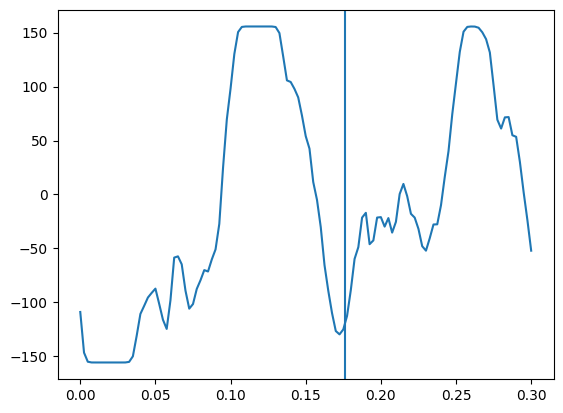

In [68]:
ts_action = jnp.linspace(0., num_t1 / kappa, 121)

opt_action = max_actions[-1,env_ind]

plt.plot(ts_action, max_actions[-1,env_ind])
plt.axvline(x=max_times[-1, env_ind])
plt.show()

In [69]:
from envs.photon_langevin_env import BatchedPhotonLangevinReadoutEnv

b_size = 2

env = BatchedPhotonLangevinReadoutEnv(
    kappa=kappa,
    chi=chi,
    batchsize=b_size,
    kerr=kerr,
    time_coeff=time_coeff,
    snr_coeff=snr_coeff,
    smoothness_coeff=smoothness_coeff,
    n0=n0,
    tau_0=tau_0,
    res_amp_scaling=res_amp_scaling,
    nR=nR,
    snr_scale_factor=snr_scale_factor,
    gamma_I=gamma_I,
    photon_gamma=photon_gamma,
    num_t1=num_t1,
    init_fid=init_fid,
    photon_weight=photon_weight
)

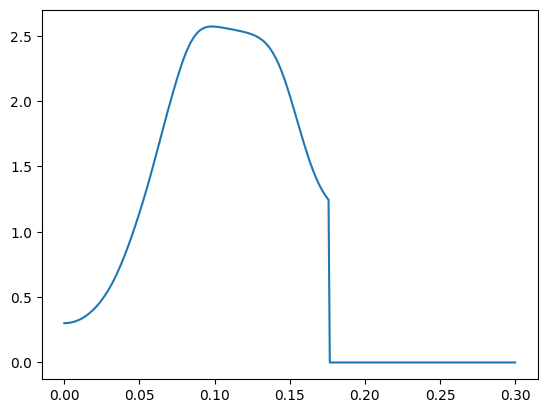

In [70]:
batch_action = jnp.tile(opt_action, (b_size, 1))

batch_results = env.batched_results(batch_action)
(
    max_pf, 
    max_photons, 
    photon_reset_time, 
    max_pf_time,
    b_smoothness, 
    b_pf, 
    b_higher_photons
) = env.batched_extract_values(batch_results, batch_action)

pF = b_pf[0]

plt.plot(env.ts_sim, pF)

In [71]:
print(photon_reset_time)

[0.17583333 0.17583333]


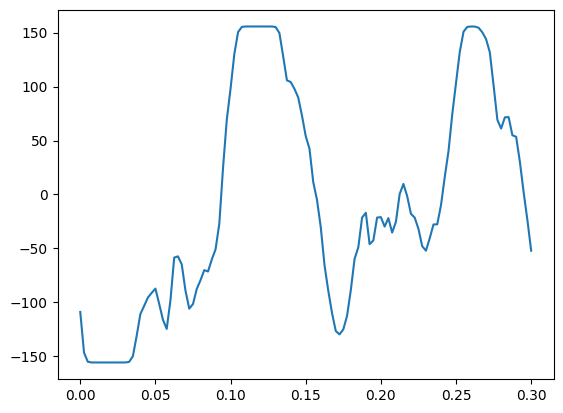

In [72]:
plt.plot(env.ts_action, opt_action)

0.06588072221856858
0.2566666666666667
0.17583333333333337


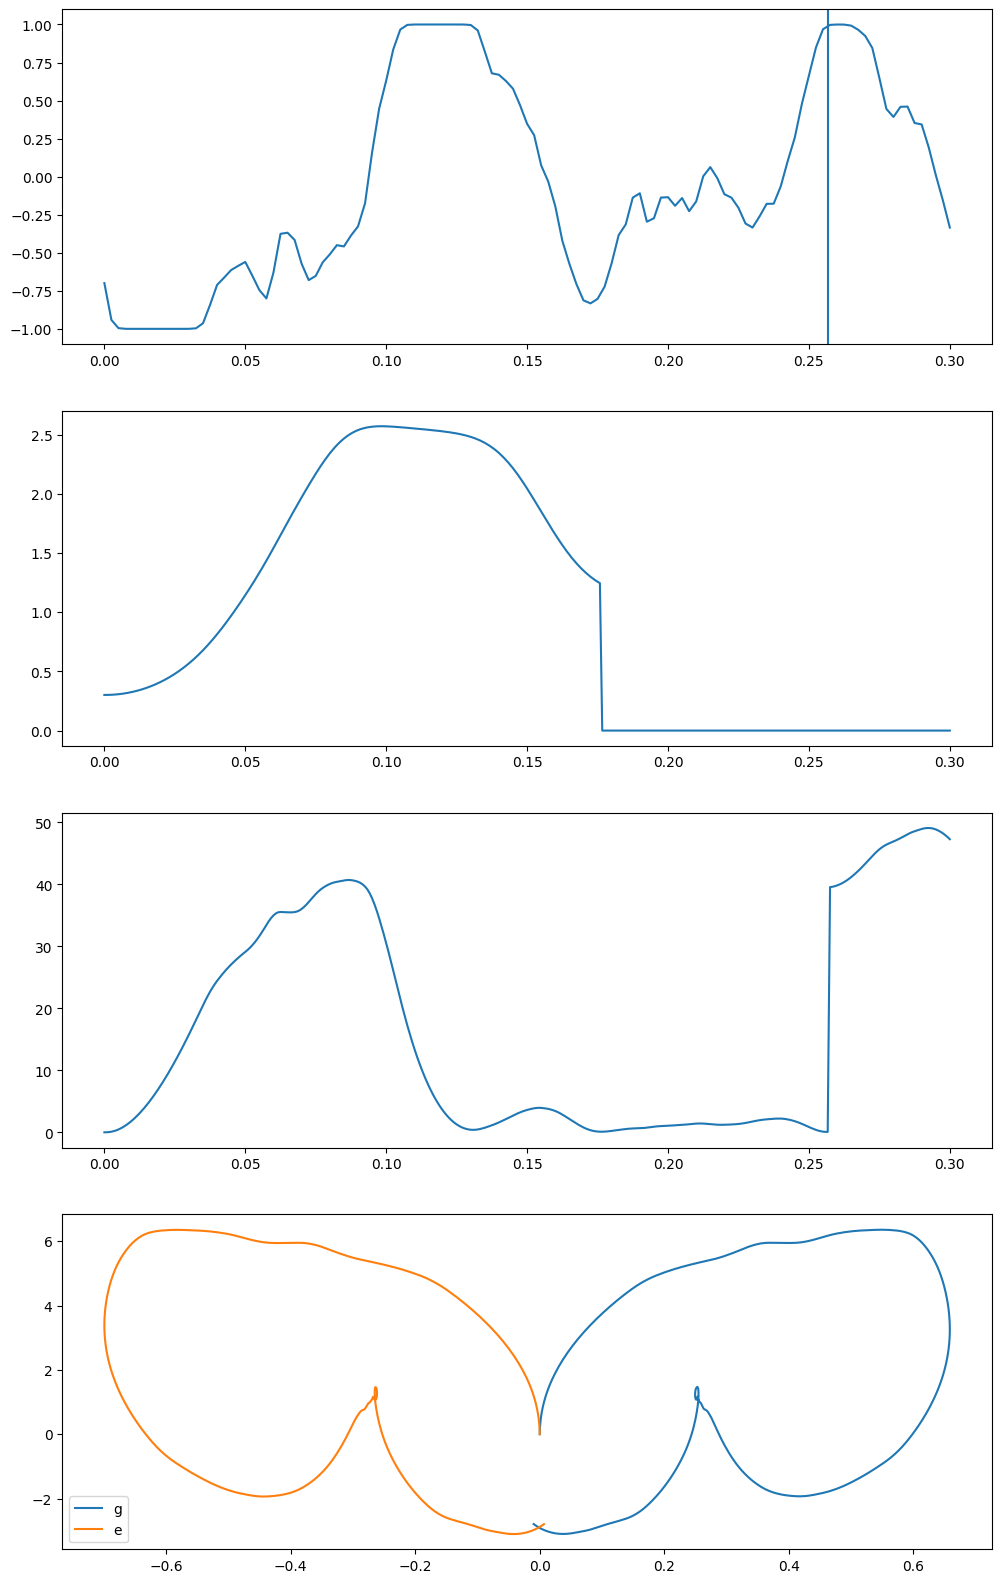

In [73]:
photon = b_higher_photons[0]
res_g_real, res_g_imag, res_e_real, res_e_imag = batch_results[0].T

fig, ax = plt.subplots(4, figsize=(12.0, 20.0))

min_photon = jnp.min(photon[45:])
min_photon_time = env.ts_sim[45 + jnp.argmin(photon[45:])]
print(min_photon)
print(min_photon_time)
print(max_times[-1, env_ind])

ax[0].plot(env.ts_action, opt_action/(env.mu * env.a0))
ax[0].axvline(x=min_photon_time)
ax[1].plot(env.ts_sim, pF)
ax[2].plot(env.ts_sim, photon)
ax[3].plot(res_g_real, res_g_imag, label='g')
ax[3].plot(res_e_real, res_e_imag, label='e')
ax[3].legend()
plt.show()

In [17]:
min_photon = jnp.min(photon[45:])
min_photon_time = env.ts_sim[45 + jnp.argmin(photon[45:])]
print(min_photon)
print(min_photon_time)

0.06354578461774393
0.03266666666666666
